## Setup

In [1]:
import reproducibility

In [2]:
# both can change
# Environment
import numpy as np
import pandas as pd
import tensorflow as tf

# Configuring the number of threads
#NUM_THREADS = 5
#tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
#tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
# from keras.utils.vis_utils import plot_model
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
import pickle, os
from utils import hash2
%matplotlib inline

In [3]:
# Local modules for handling data and running moisture models
import data_funcs as datf
from data_funcs import format_raws, retrieve_raws, format_precip, fixnan, load_and_fix_data
from data_funcs import raws_data, synthetic_data, plot_data, check_data, rmse_data, to_json, from_json
import moisture_models as mod
from moisture_rnn import run_case, run_rnn, create_RNN_2, staircase, create_rnn_data, train_rnn, rnn_predict

## User options

In [4]:
# Change directory for data read/write

dict_file='data/testing_dict.pickle' # input path of FMDA dictionaries
output_path='outputs/outputs.json' # RNN output file
reproducibility_file='data/reproducibility_dict.pickle'

In [5]:
param_sets={}

In [6]:
param_sets.update({0:{'id':0,
        'purpose':'reproducibility',
        'batch_size':np.inf,
        'training':None,
        'cases':['case11'],
        'scale':0,
        'rain_do':False,
#        'verbose':False,
        'verbose':1,
        'timesteps':5,
        'activation':['linear','linear'],
        'centering':[0.0,0.0],
        'hidden_units':6,
        'dense_units':1,
        'dense_layers':1,
        'DeltaE':[0,-1],    # -1.0 is to correct E bias but put at the end
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 2.0,         # fm increase per mm rain                              
        'epochs':5000,
        'verbose_fit':False,
        'verbose_weights':False,
        'note':'check 5 should give zero error'
}})

In [7]:
param_sets.update({1:{'id':1,
        'purpose':'test 1',
        'batch_size':32,
        'training':5,
        'cases':'all',
        'scale':1,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['linear','linear'],
        'hidden_units':20,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'centering':[0.0,0.0],  # should be activation at 0
        'DeltaE':[0,-1],    # bias correction
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 0.2,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':100,
        'verbose_fit':False,
        'verbose_weights':False,
}})

In [8]:
param_sets.update({2:{'id':2,
        'purpose':'test 2',
        'batch_size':32,
        'training':5,
        'cases':'all',
        'scale':0.8,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['tanh','tanh'],
        'hidden_units':20,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'DeltaE':[0,-1],    # bias correction
        'centering':[0.0,0.0],  # should be activation at 0
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 0.2,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':10000,
        'verbose_fit':False,
        'verbose_weights':False,
}})

In [9]:
param_sets.update({3:{'id':3,
        'purpose':'test 3',
        'batch_size':32,
        'training':5,
        'cases':'all',
        'scale':0.8,        # every feature in [0, scale]
        'rain_do':True,
        'verbose':False,
        'timesteps':5,
        'activation':['sigmoid','sigmoid'],
        'hidden_units':20,  
        'dense_units':1,    # do not change
        'dense_layers':1,   # do not change
        'DeltaE':[0,0],    # bias correction
        'centering':[0.5,0.5],  # should be activation at 0
        'synthetic':False,  # run also synthetic cases
        'T1': 0.1,          # 1/fuel class (10)
        'fm_raise_vs_rain': 0.2,         # fm increase per mm rain 
        'train_frac':0.5,  # time fraction to spend on training
        'epochs':10000,
        'verbose_fit':False,
        'verbose_weights':False,
}})

In [10]:
# read test datasets
test_dict={}
test_dict.update(load_and_fix_data(dict_file))
print(test_dict.keys())

repro_dict={}
repro_dict.update(load_and_fix_data(reproducibility_file))
print(repro_dict.keys())

After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
After fixing, remained 0 nan values
dict_keys(['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'])
dict_keys(['case11'])


params_sets.keys()= dict_keys([0, 1, 2, 3])
{
    "0": {
        "DeltaE": [
            0,
            -1
        ],
        "T1": 0.1,
        "activation": [
            "linear",
            "linear"
        ],
        "batch_size": Infinity,
        "cases": [
            "case11"
        ],
        "centering": [
            0.0,
            0.0
        ],
        "dense_layers": 1,
        "dense_units": 1,
        "epochs": 5000,
        "fm_raise_vs_rain": 2.0,
        "hidden_units": 6,
        "id": 0,
        "note": "check 5 should give zero error",
        "purpose": "reproducibility",
        "rain_do": false,
        "scale": 0,
        "synthetic": false,
        "timesteps": 5,
        "training": null,
        "verbose": 1,
        "verbose_fit": false,
        "verbose_weights": false
    },
    "1": {
        "DeltaE": [
            0,
            -1
        ],
        "T1": 0.1,
        "activation": [
            "linear",
            "linear"
        ],
        

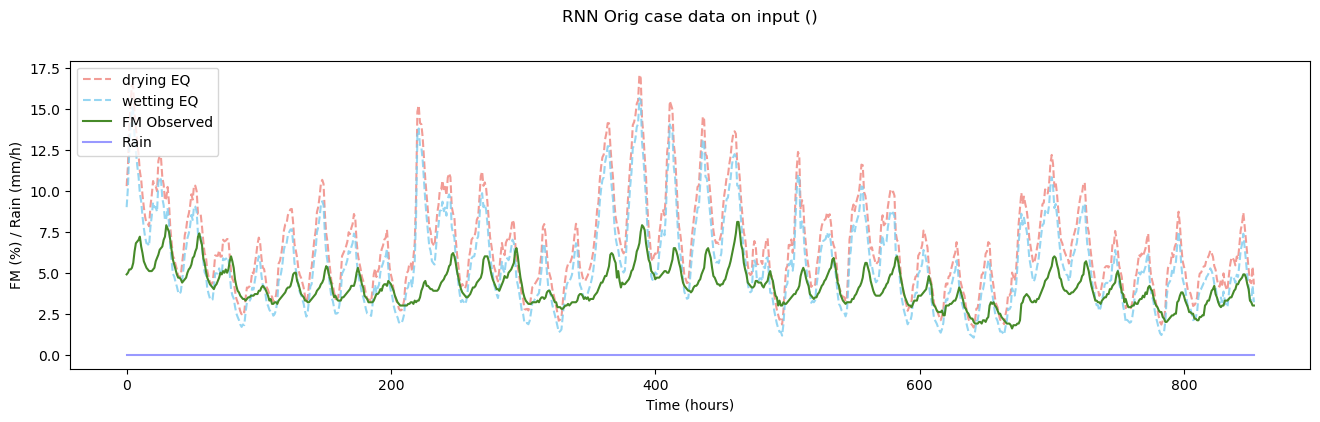

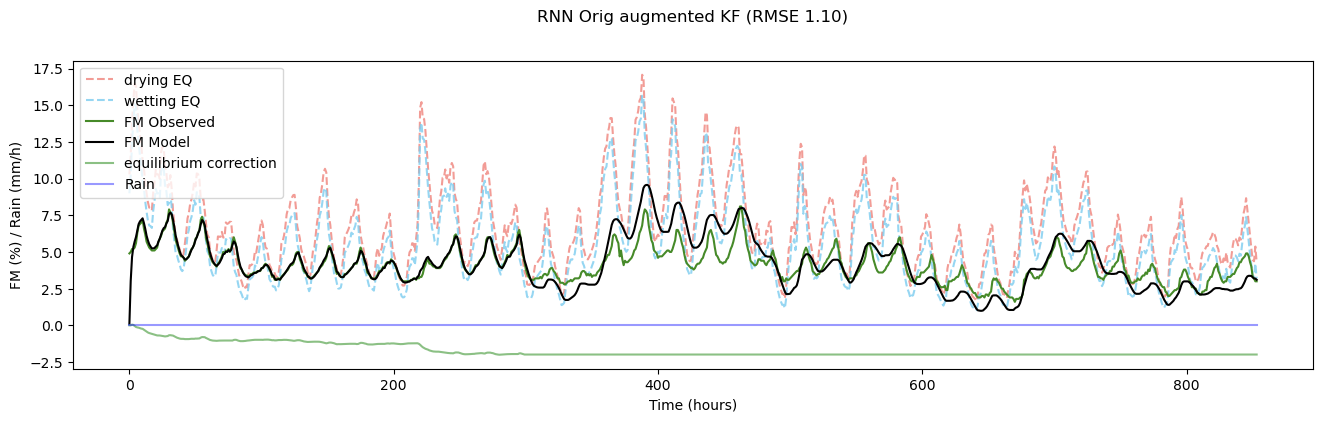

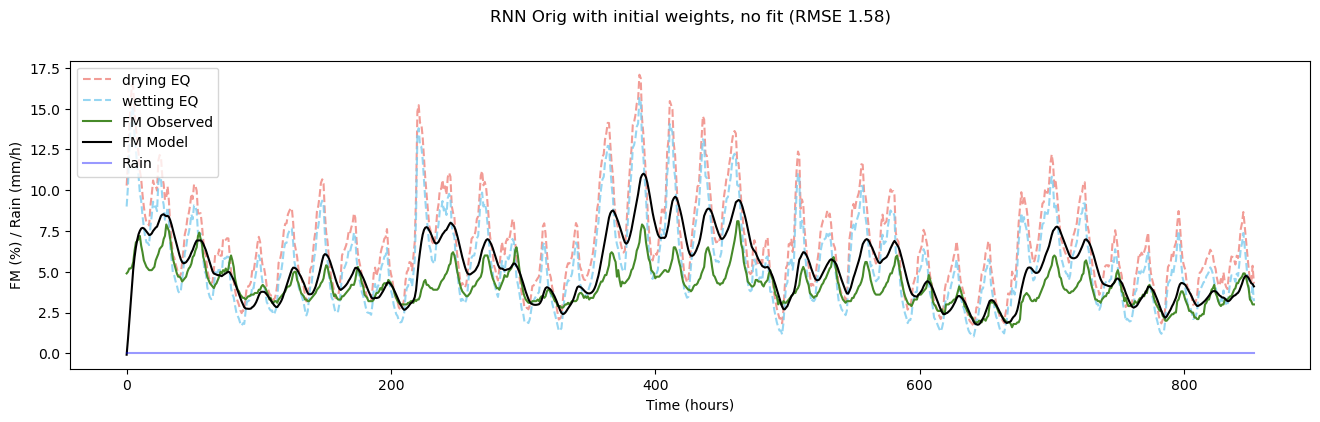

case11 Training 1 to 300 hours RMSE:   1.327
case11 Prediction 301 to 854 hours RMSE: 1.5834
resetting random seeds to 123
create_rnn_data: hours= 854  h2= 300
batch_size= inf
staircase: shape x =  (854, 2)
staircase: shape y =  (854, 1)
staircase: timesteps= 5
staircase: datapoints= 300
staircase: return_sequences= False
staircase: samples= 296 timesteps= 5 features= 2
returning only the last timestep in a sample
x_train shape= (296, 5, 2)
y_train shape= (296, 1)
rnn_dat
items: ['hours', 'x_train', 'y_train', 'Et', 'samples', 'timesteps', 'features', 'h0', 'h2', 'scale', 'scale_fm', 'scale_rain', 'rain_do', 'features_list']
hours = 854   <class 'int'>
<class 'numpy.ndarray'>
array x_train shape (296, 5, 2) min 1.6974029070178052 max 16.49195767995983 hash 14769812307992047695 type <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
array y_train shape (296, 1) min 3.0 max 7.9 hash 10119650379183749962 type <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
array Et shape (854, 2) min 1.03856

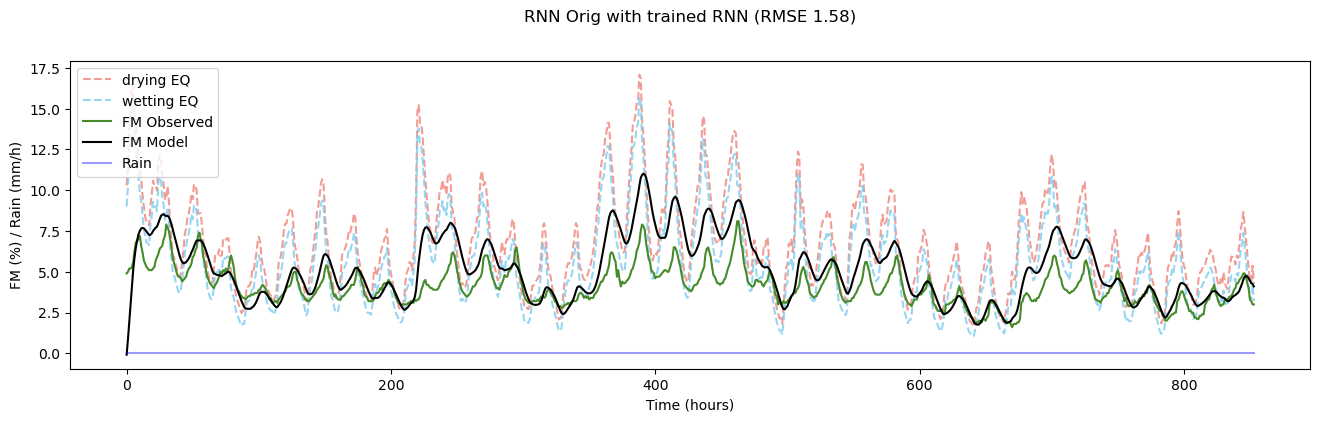

case11 Training 1 to 300 hours RMSE:   1.327
case11 Prediction 301 to 854 hours RMSE: 1.5834
*** params 0 reproducibility case summary ***
params= {'id': 0, 'purpose': 'reproducibility', 'batch_size': inf, 'training': None, 'cases': ['case11'], 'scale': 0, 'rain_do': False, 'verbose': 1, 'timesteps': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'hidden_units': 6, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 2.0, 'epochs': 5000, 'verbose_fit': False, 'verbose_weights': False, 'note': 'check 5 should give zero error'}
outputs= {
    "Augmented KF": {
        "all": 0.9061249439407393,
        "predict": 1.0984268618847821,
        "train": 0.33047073142627476
    },
    "RNN initial": {
        "all": 1.4983486205665615,
        "predict": 1.58343693275214,
        "train": 1.3269545567623797
    },
    "RNN trained": {
        "all": 1.4983486205665615,
        "predict": 1.58343693275214,
        "train": 

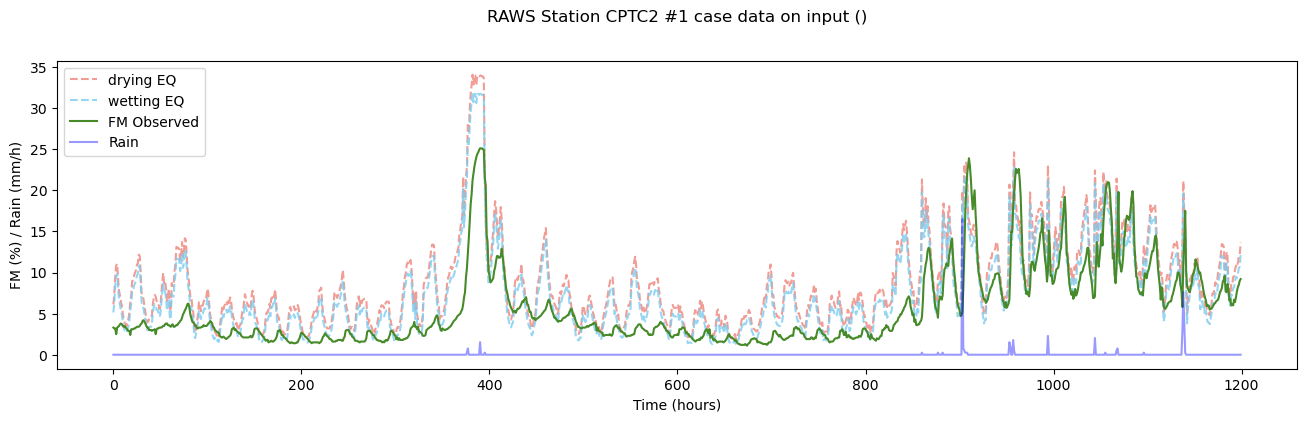

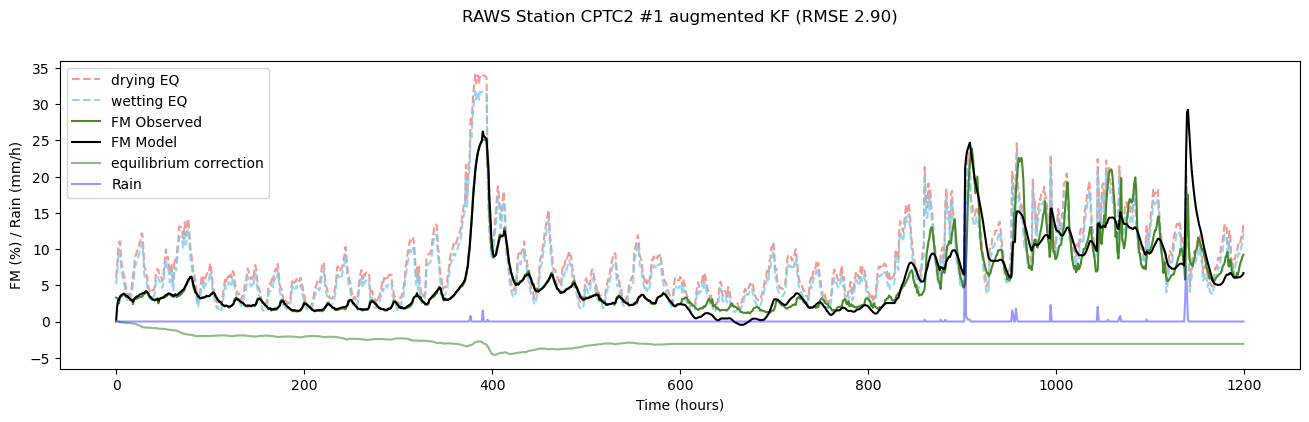

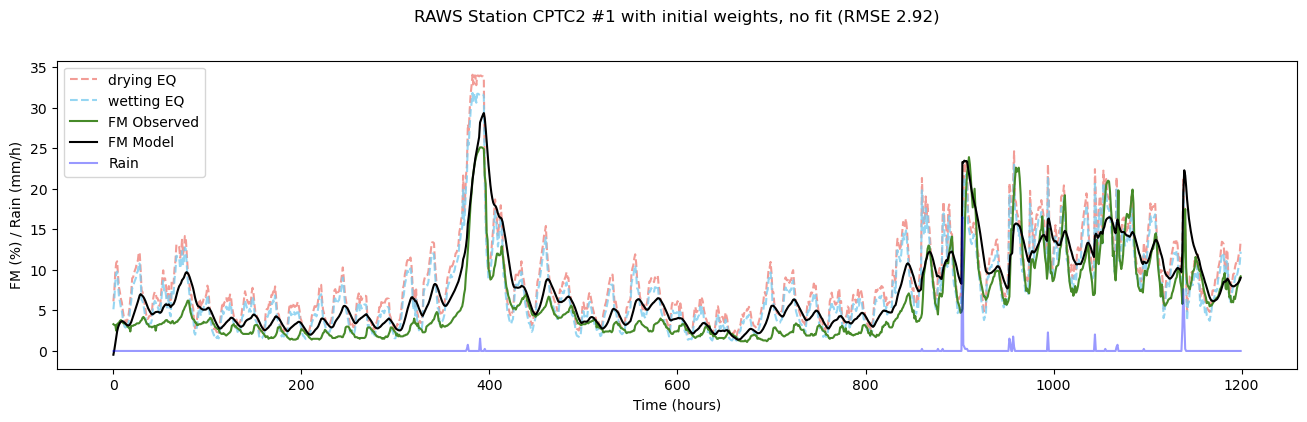

case7 Training 1 to 600 hours RMSE:   2.586
case7 Prediction 601 to 1200 hours RMSE: 2.9185
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting state

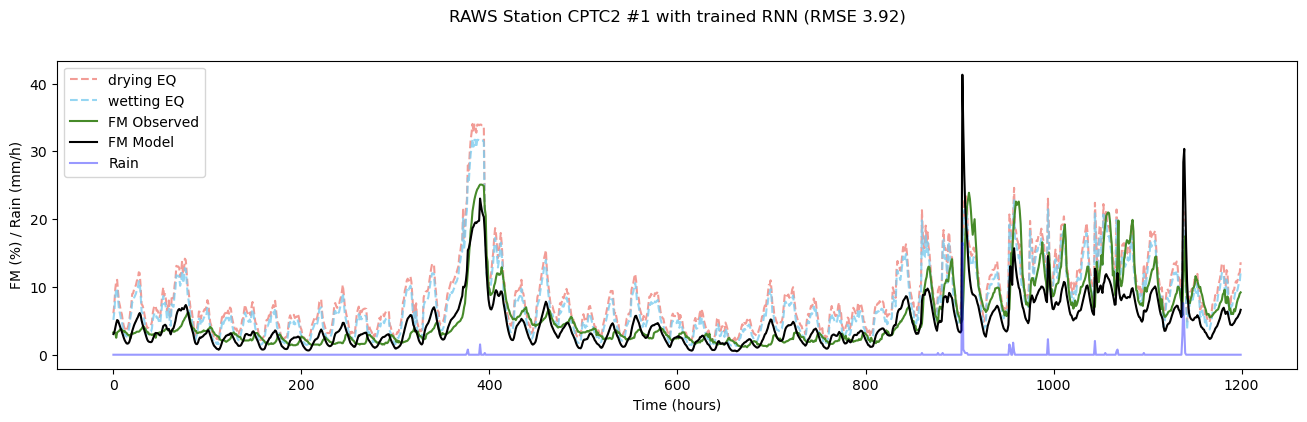

case7 Training 1 to 600 hours RMSE:   1.5967
case7 Prediction 601 to 1200 hours RMSE: 3.9248
*** params 1 case case7 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 2.062032898281509,
        "predict": 2.9044740769065704,
        "train": 0.2607483149863215
    },
    "RNN initial": {
        "all": 2.7572800061397373,
        "predict": 2.918549797296703,
        "train": 2.585972379051113
    },
    "RNN trained": {
        "all": 2.996150

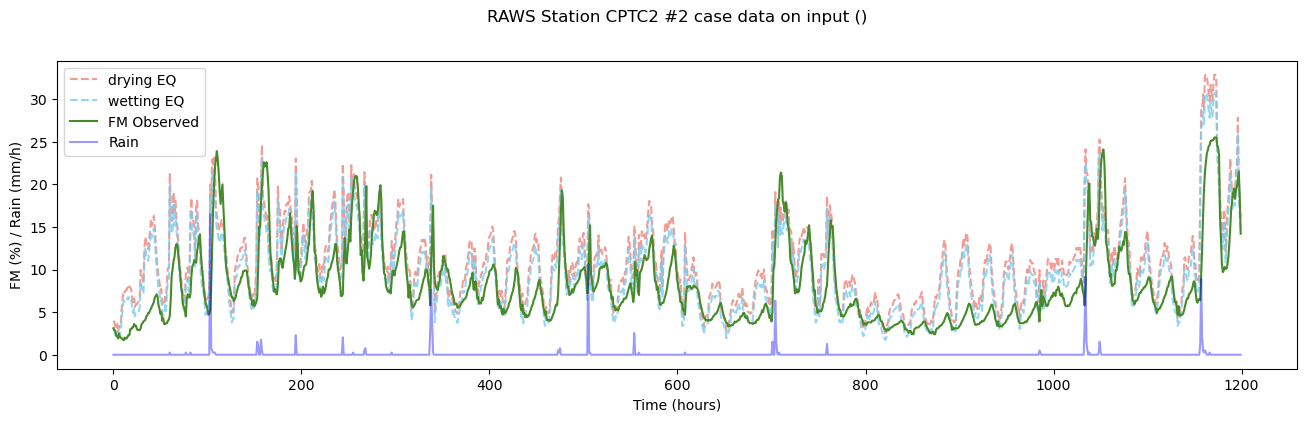

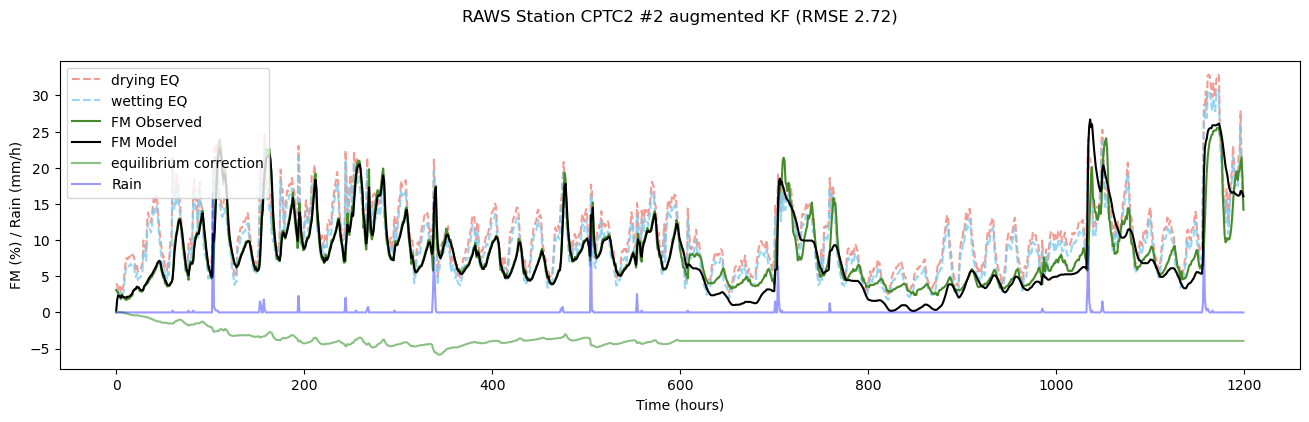

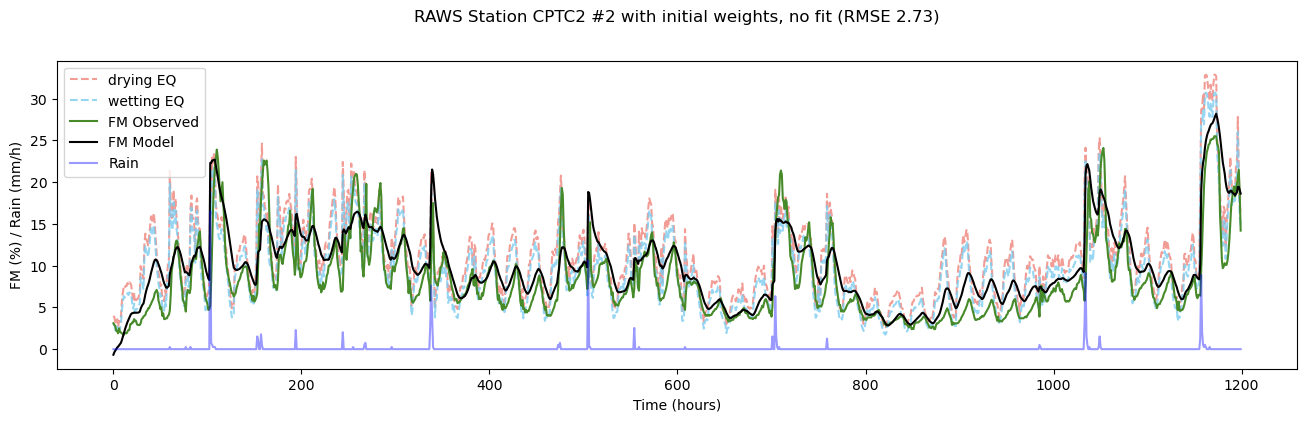

case8 Training 1 to 600 hours RMSE:   3.0674
case8 Prediction 601 to 1200 hours RMSE: 2.7337
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting stat

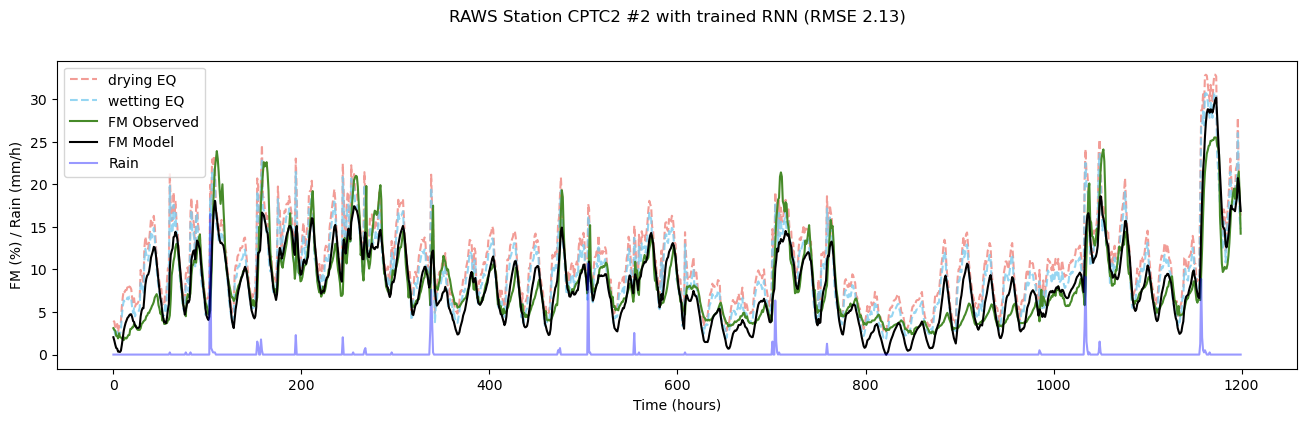

case8 Training 1 to 600 hours RMSE:   2.1272
case8 Prediction 601 to 1200 hours RMSE: 2.1273
*** params 1 case case8 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 1.9797317663128065,
        "predict": 2.7168888577236636,
        "train": 0.676158759370206
    },
    "RNN initial": {
        "all": 2.9053346146329684,
        "predict": 2.7337319971782197,
        "train": 3.067351922028671
    },
    "RNN trained": {
        "all": 2.12721

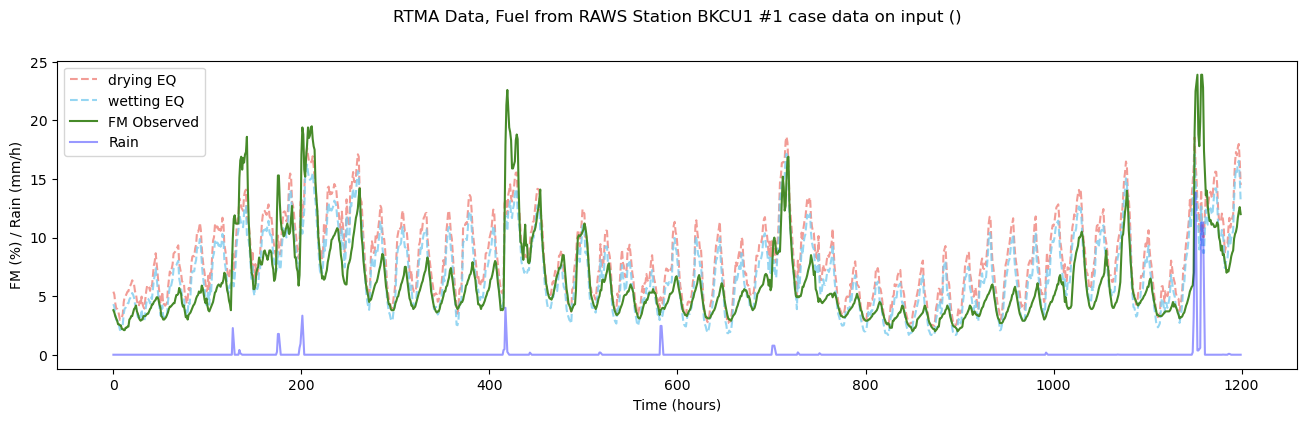

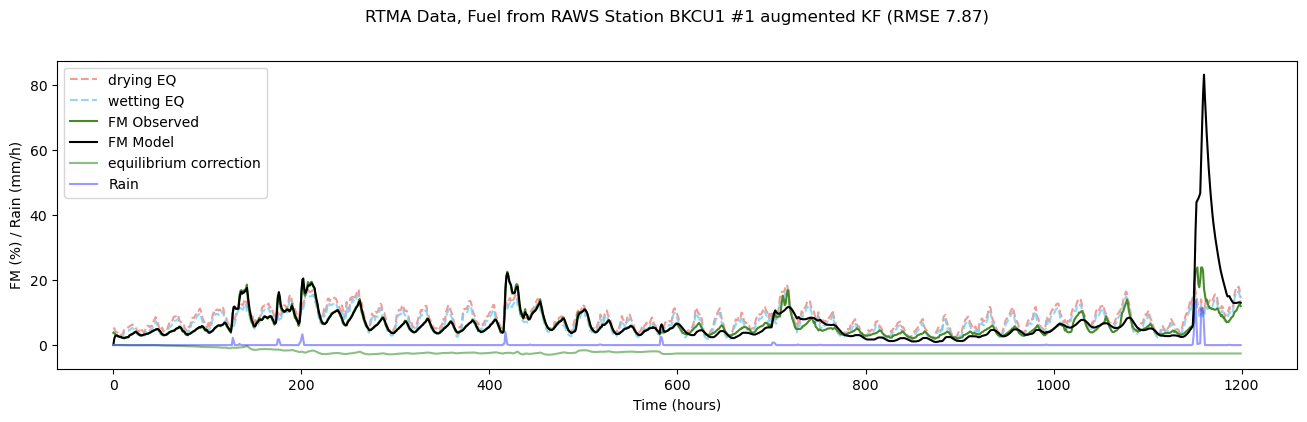

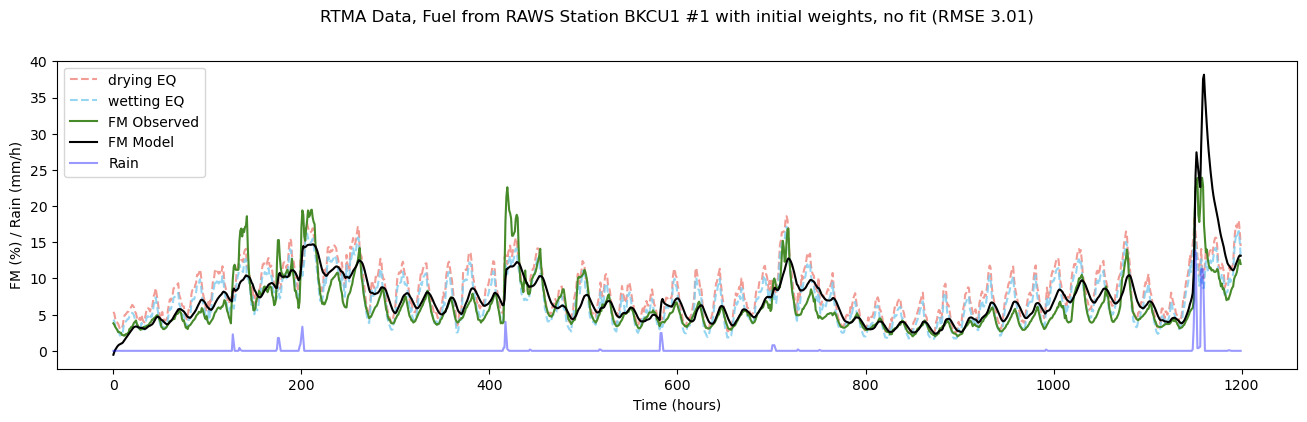

case9 Training 1 to 600 hours RMSE:   2.3098
case9 Prediction 601 to 1200 hours RMSE: 3.0101
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting stat

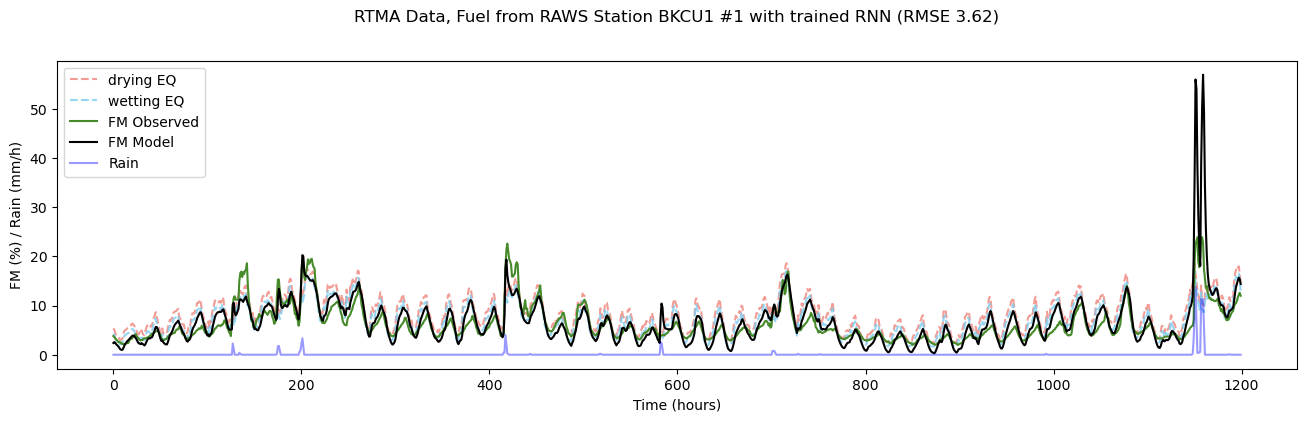

case9 Training 1 to 600 hours RMSE:   1.8366
case9 Prediction 601 to 1200 hours RMSE: 3.6187
*** params 1 case case9 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 5.574818223890552,
        "predict": 7.871270021958024,
        "train": 0.4475541311052058
    },
    "RNN initial": {
        "all": 2.6828752587609044,
        "predict": 3.0100515942338233,
        "train": 2.309811401000782
    },
    "RNN trained": {
        "all": 2.869522

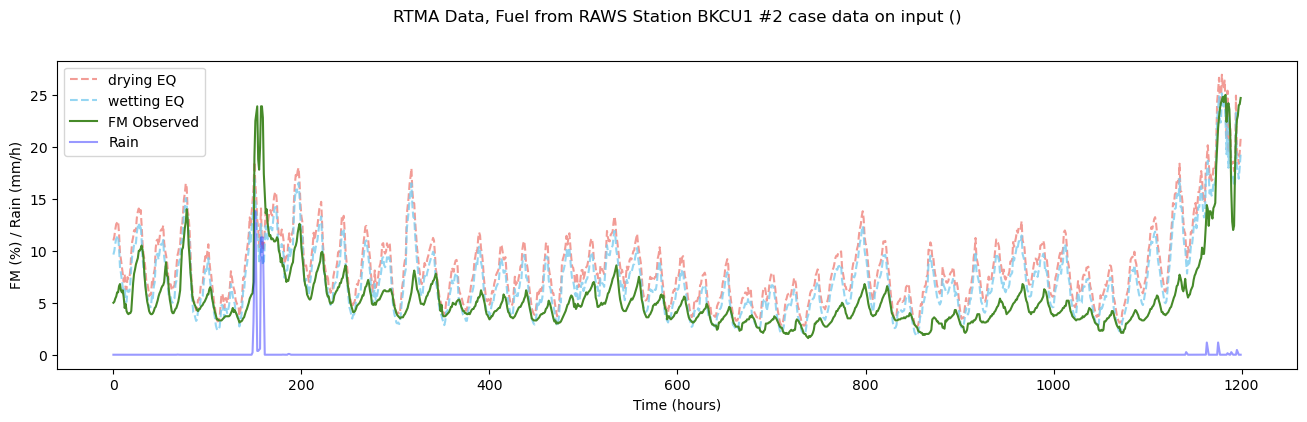

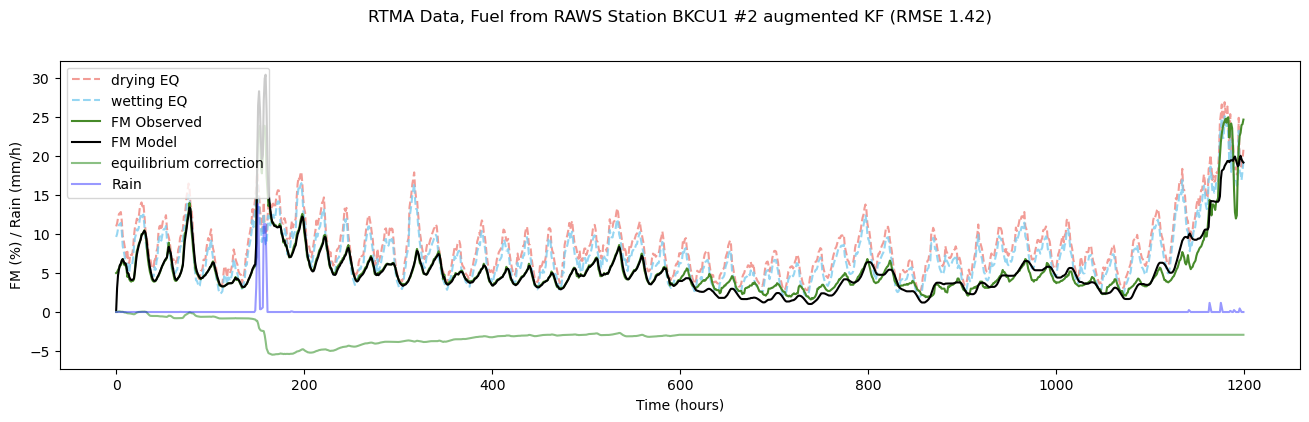

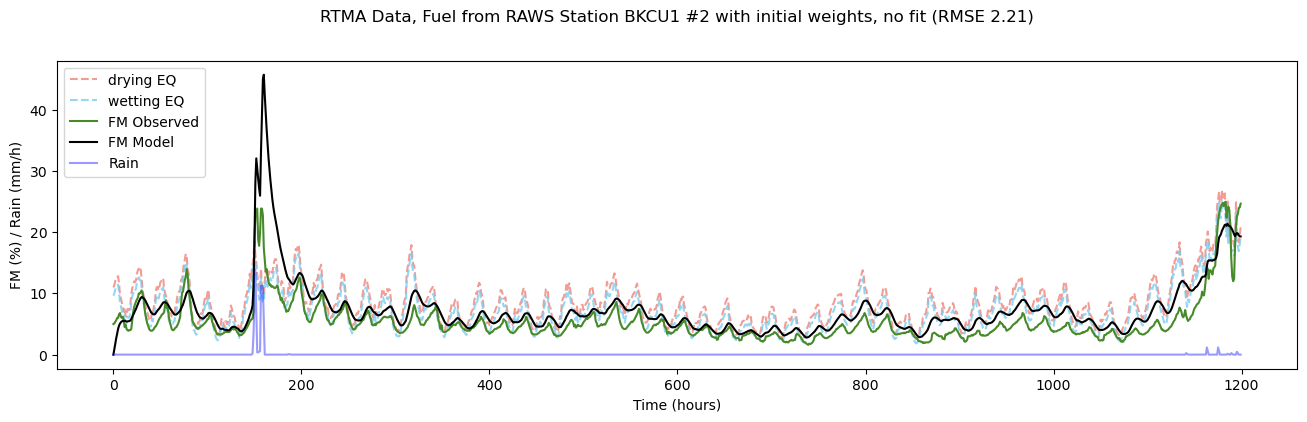

case10 Training 1 to 600 hours RMSE:   3.9088
case10 Prediction 601 to 1200 hours RMSE: 2.2071
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting st

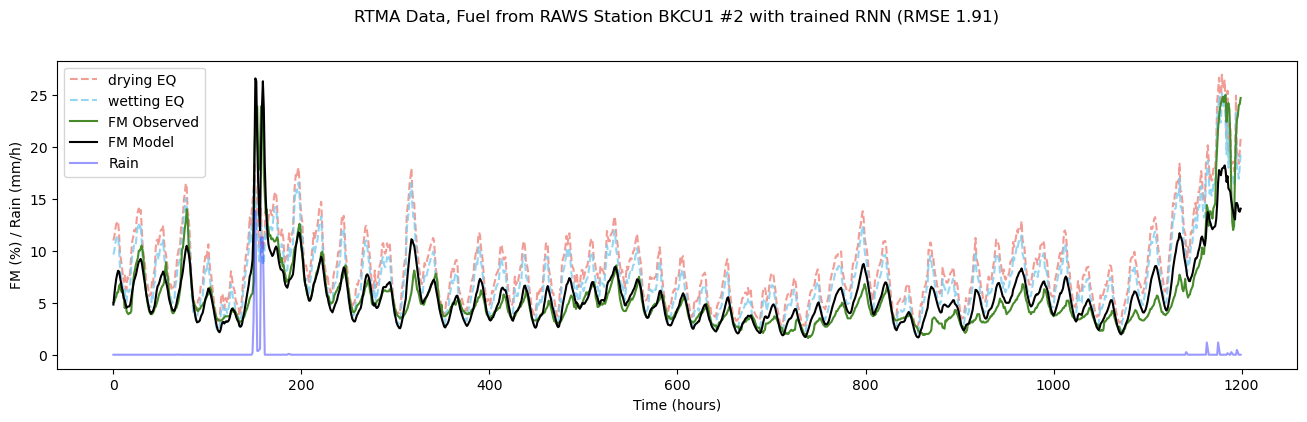

case10 Training 1 to 600 hours RMSE:   1.1325
case10 Prediction 601 to 1200 hours RMSE: 1.9104
*** params 1 case case10 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 1.124729422409734,
        "predict": 1.4170835271066387,
        "train": 0.72243119012905
    },
    "RNN initial": {
        "all": 3.1741443701067795,
        "predict": 2.2071499886894985,
        "train": 3.90882001273902
    },
    "RNN trained": {
        "all": 1.57041

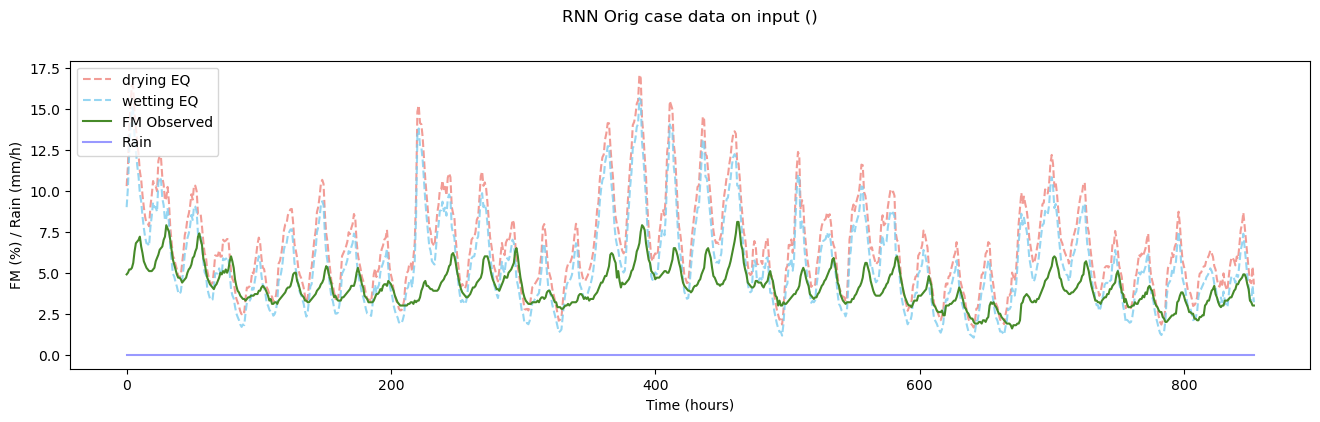

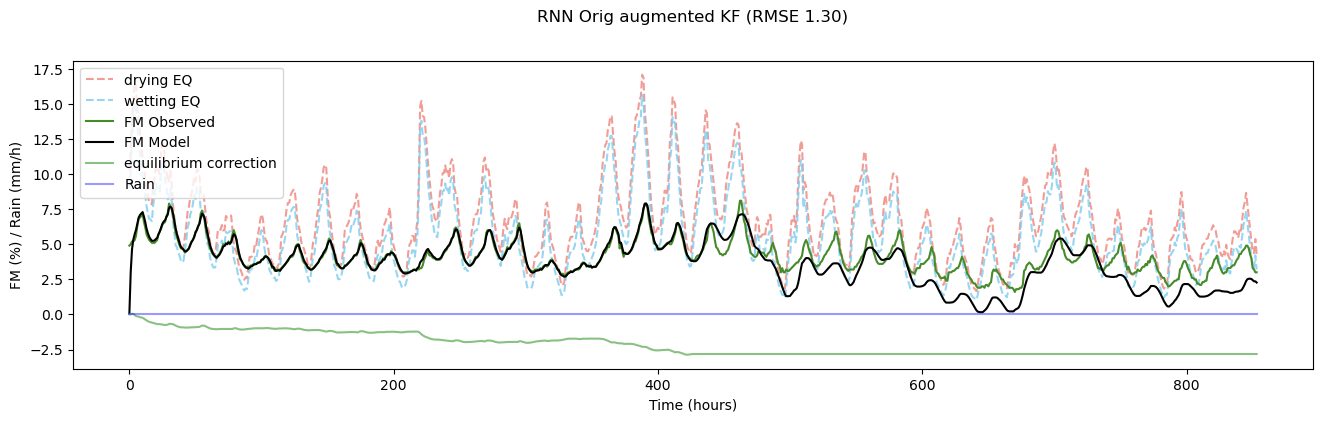

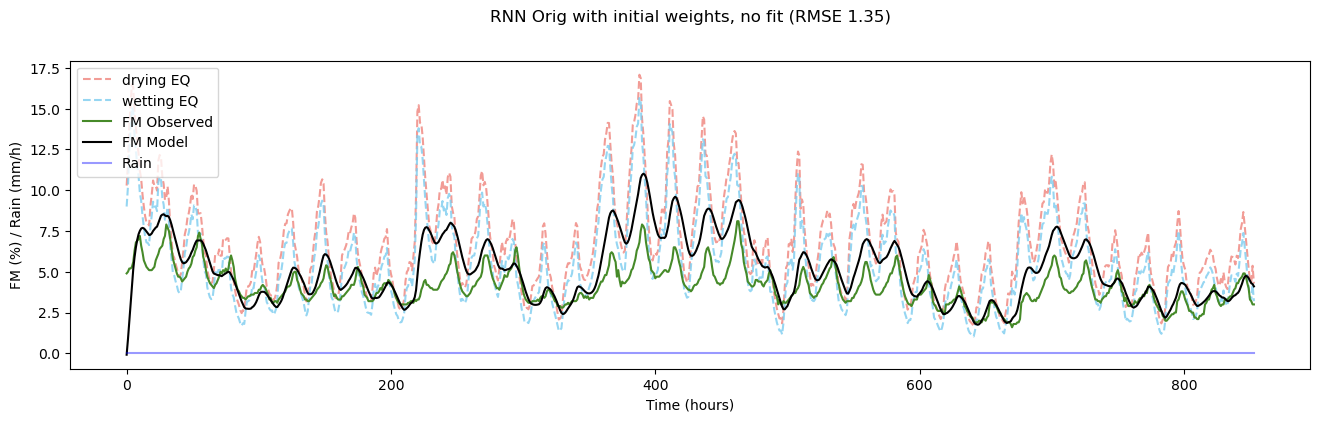

case11 Training 1 to 427 hours RMSE:   1.6341
case11 Prediction 428 to 854 hours RMSE: 1.349
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (854, 3)
staircase_2: shape y =  (854, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 427
staircase_2: max_batches= 85
staircase_2: max_sequences= 2720
staircase_2: shape x_train =  (2720, 5, 3)
staircase_2: shape y_train =  (2720, 1)
staircase_2: sequences generated 2621
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 2592
staircase_2: shape x_train =  (2592, 5, 3)
staircase_2: shape y_train =  (2592, 1)
train_rnn : samples = 2592
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (2592, 5, 3)
y_train shape = (2592, 1)
training in one pass, resetting state a

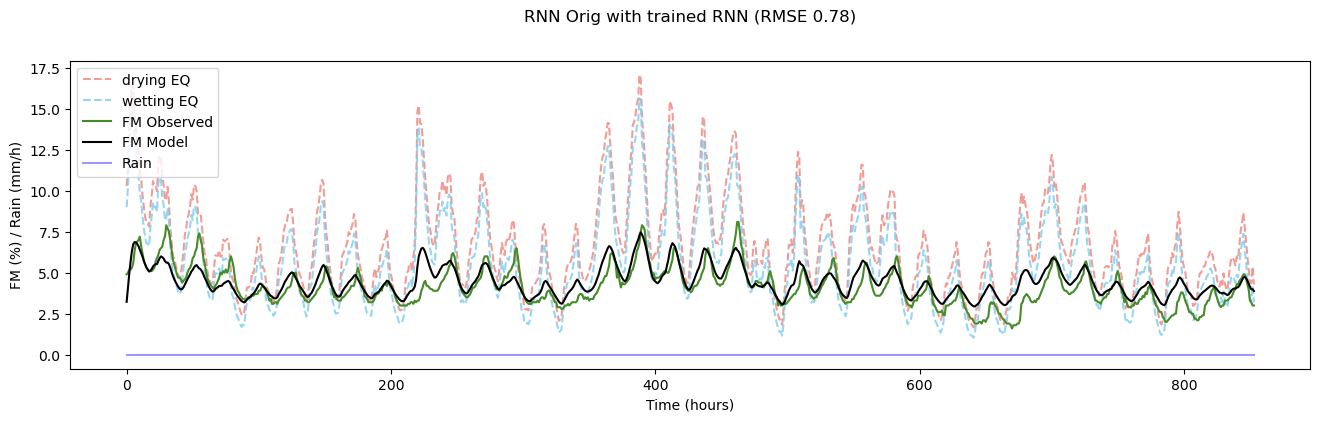

case11 Training 1 to 427 hours RMSE:   0.7058
case11 Prediction 428 to 854 hours RMSE: 0.7834
*** params 1 case case11 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 0.9381104126731539,
        "predict": 1.2955200737612529,
        "train": 0.28588464669028313
    },
    "RNN initial": {
        "all": 1.4983481199770357,
        "predict": 1.3489755877288487,
        "train": 1.6341233249020841
    },
    "RNN trained": {
        "all": 0.

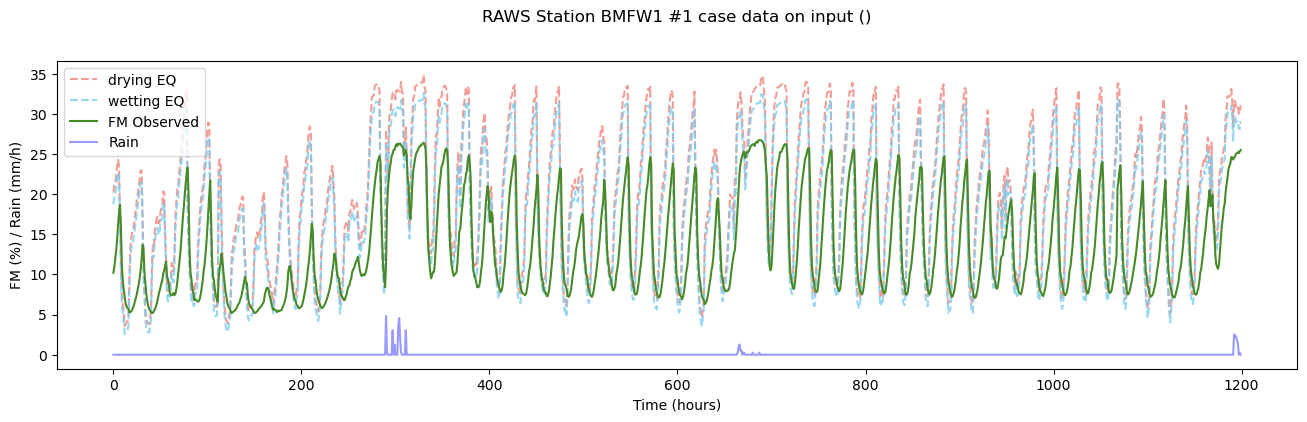

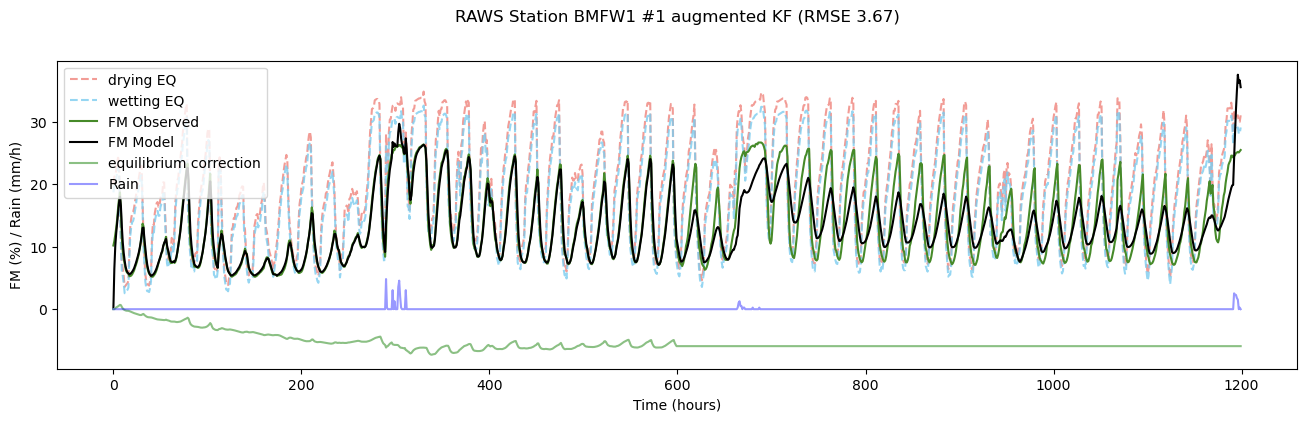

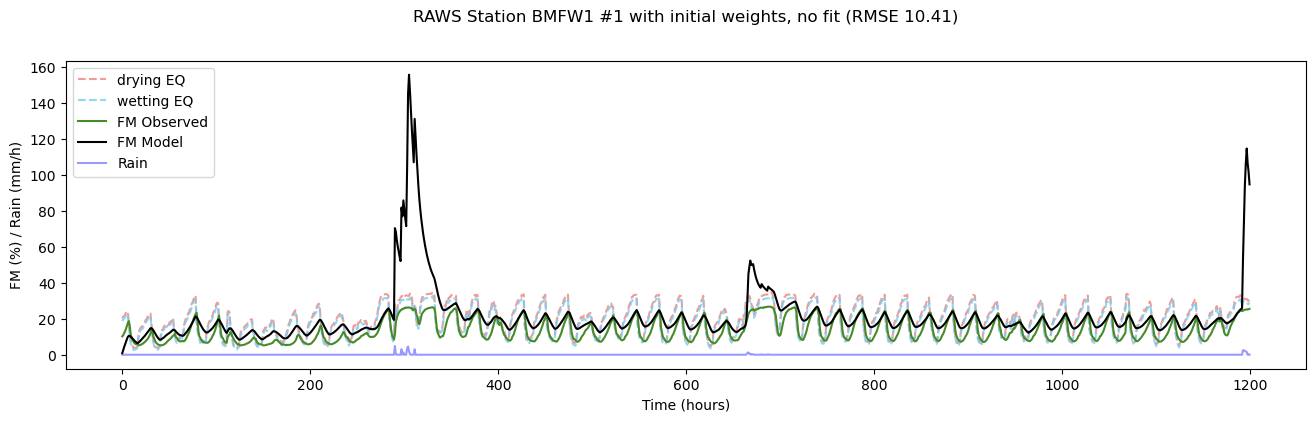

case12 Training 1 to 600 hours RMSE:   18.3146
case12 Prediction 601 to 1200 hours RMSE: 10.4065
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting 

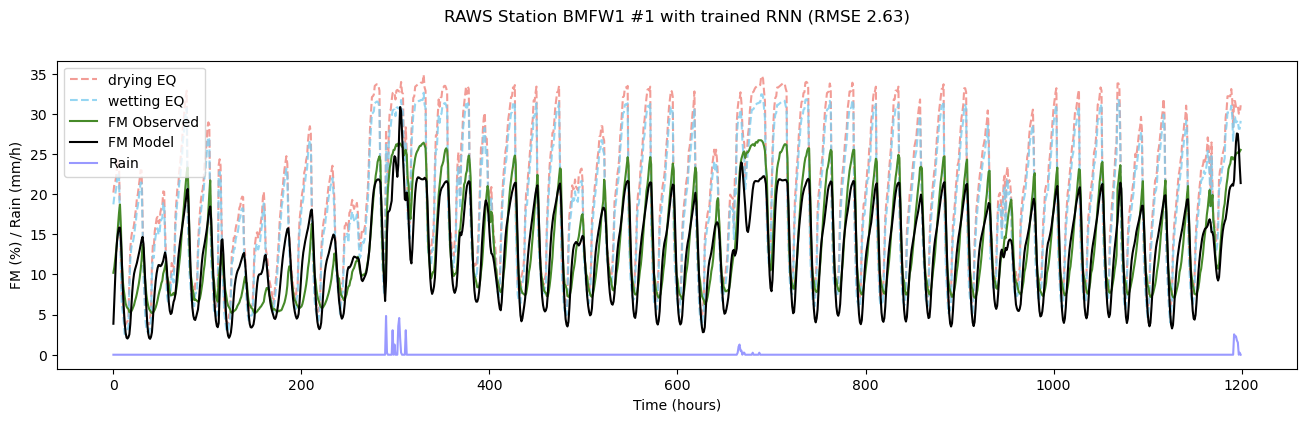

case12 Training 1 to 600 hours RMSE:   2.7011
case12 Prediction 601 to 1200 hours RMSE: 2.6347
*** params 1 case case12 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 2.6575371949630515,
        "predict": 3.6659602477718107,
        "train": 0.8280962184317805
    },
    "RNN initial": {
        "all": 14.89496065742019,
        "predict": 10.406503486650447,
        "train": 18.314595031136307
    },
    "RNN trained": {
        "all": 2.6

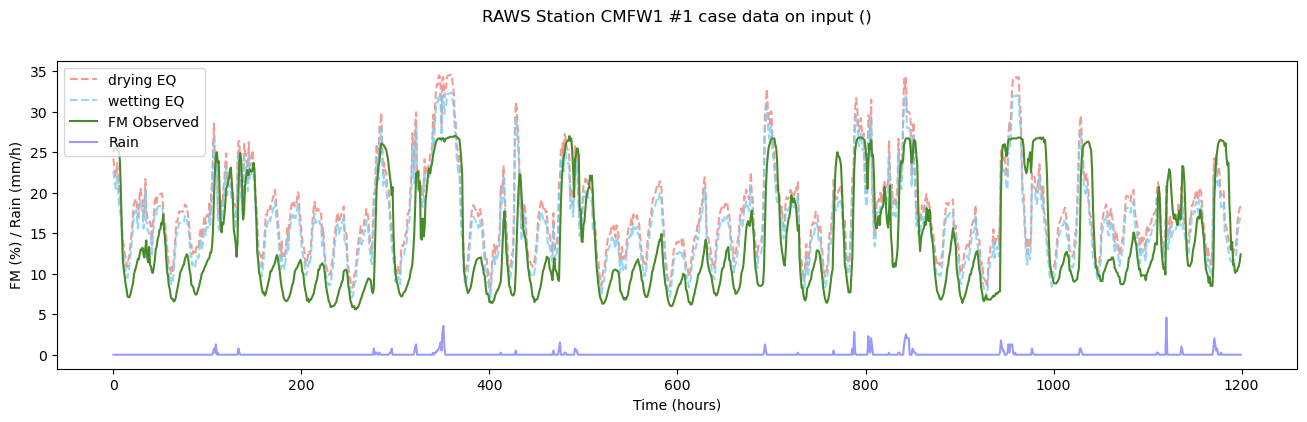

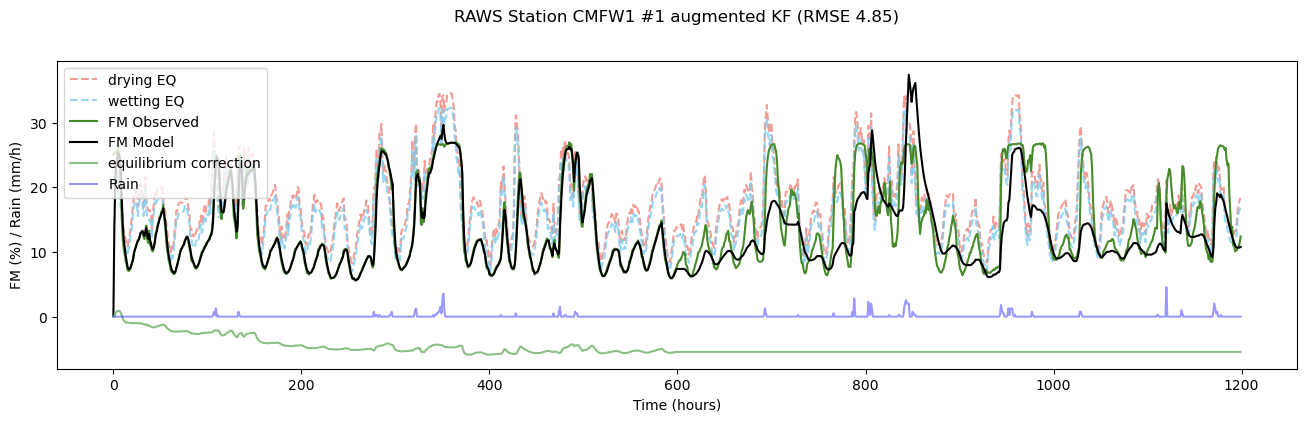

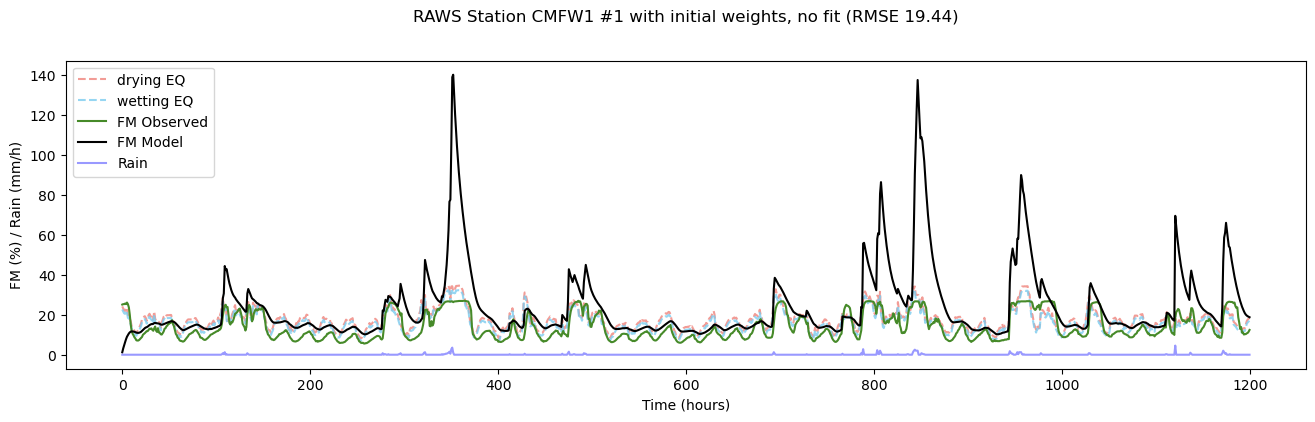

case13 Training 1 to 600 hours RMSE:   15.1284
case13 Prediction 601 to 1200 hours RMSE: 19.4396
resetting random seeds to 123
scaling to range 0 to 1
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 100
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting 

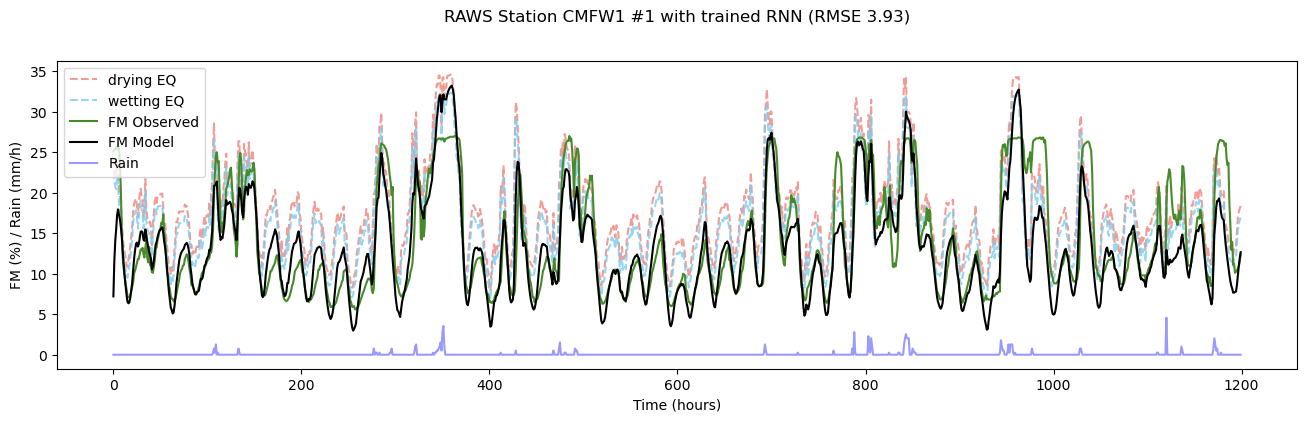

case13 Training 1 to 600 hours RMSE:   2.8884
case13 Prediction 601 to 1200 hours RMSE: 3.9343
*** params 1 case case13 summary ***
params= {'id': 1, 'purpose': 'test 1', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 1, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['linear', 'linear'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'centering': [0.0, 0.0], 'DeltaE': [0, -1], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 100, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 3.5554592800141718,
        "predict": 4.853275693575417,
        "train": 1.3146468825611861
    },
    "RNN initial": {
        "all": 17.41790235392838,
        "predict": 19.43960239318727,
        "train": 15.128400563732946
    },
    "RNN trained": {
        "all": 3.451

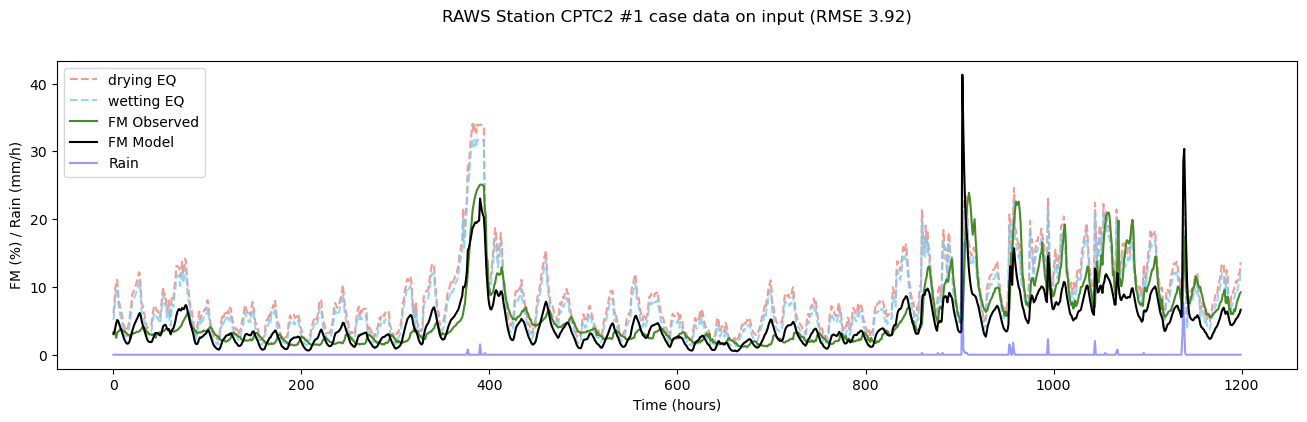

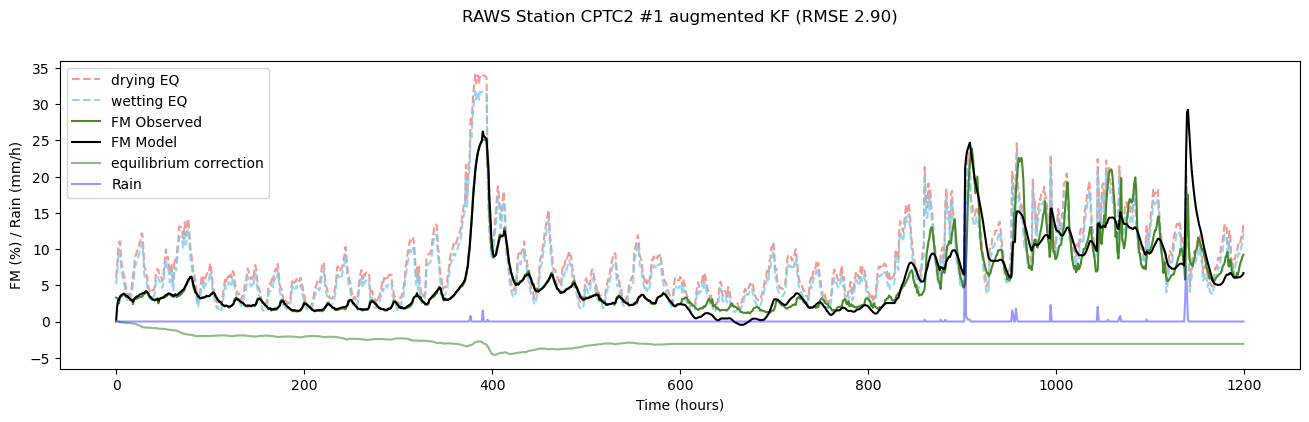

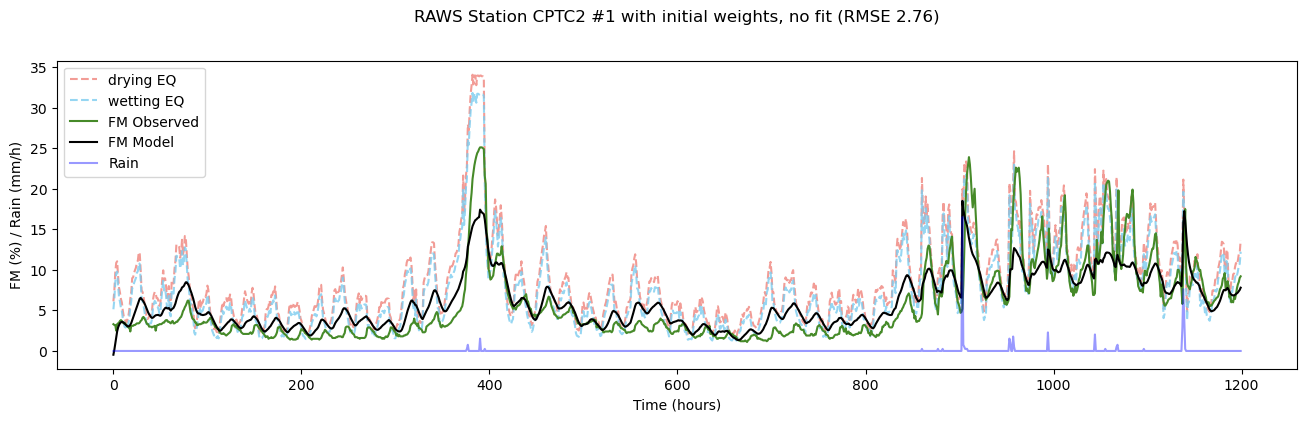

case7 Training 1 to 600 hours RMSE:   1.9789
case7 Prediction 601 to 1200 hours RMSE: 2.7594
resetting random seeds to 123
scaling to range 0 to 0.8
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 10000
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting 

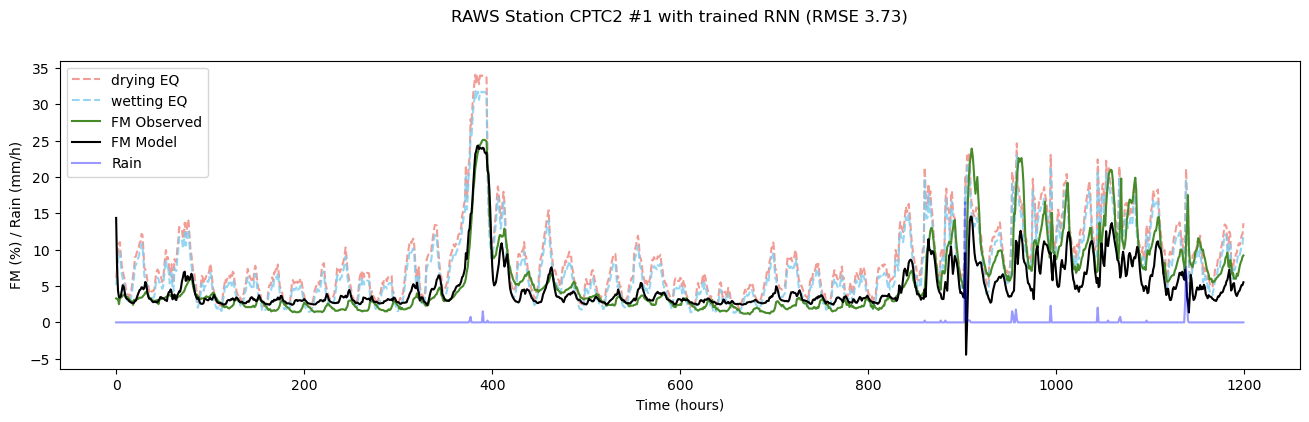

case7 Training 1 to 600 hours RMSE:   1.2695
case7 Prediction 601 to 1200 hours RMSE: 3.7289
*** params 2 case case7 summary ***
params= {'id': 2, 'purpose': 'test 2', 'batch_size': 32, 'training': 5, 'cases': ['case1', 'case2', 'case3', 'case4', 'case5', 'case6', 'case7', 'case8', 'case9', 'case10', 'case11', 'case12', 'case13'], 'scale': 0.8, 'rain_do': True, 'verbose': False, 'timesteps': 5, 'activation': ['tanh', 'tanh'], 'hidden_units': 20, 'dense_units': 1, 'dense_layers': 1, 'DeltaE': [0, -1], 'centering': [0.0, 0.0], 'synthetic': False, 'T1': 0.1, 'fm_raise_vs_rain': 0.2, 'train_frac': 0.5, 'epochs': 10000, 'verbose_fit': False, 'verbose_weights': False}
outputs= {
    "Augmented KF": {
        "all": 2.062032898281509,
        "predict": 2.9044740769065704,
        "train": 0.2607483149863215
    },
    "RNN initial": {
        "all": 2.4011126409701826,
        "predict": 2.759429107606503,
        "train": 1.978947909710508
    },
    "RNN trained": {
        "all": 2.785346

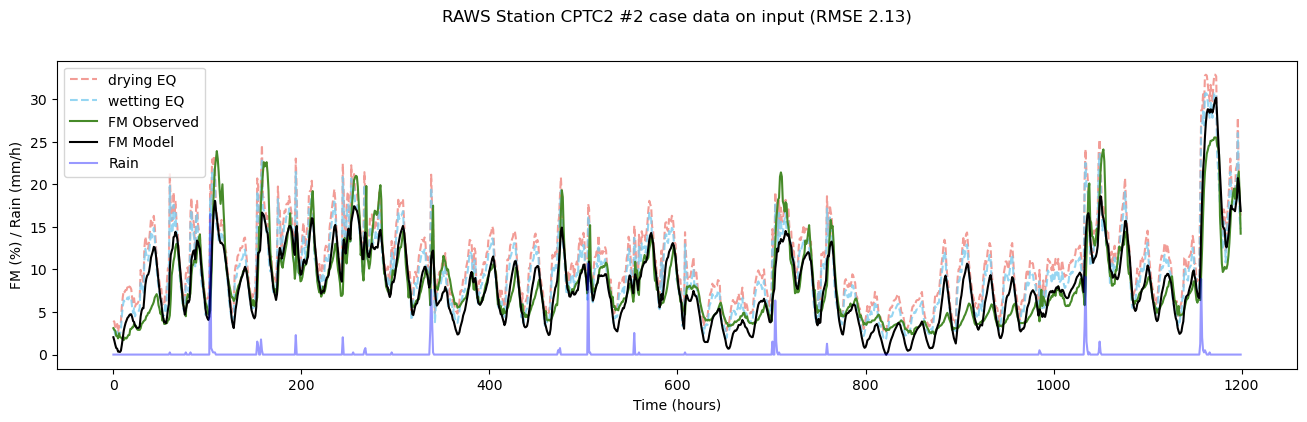

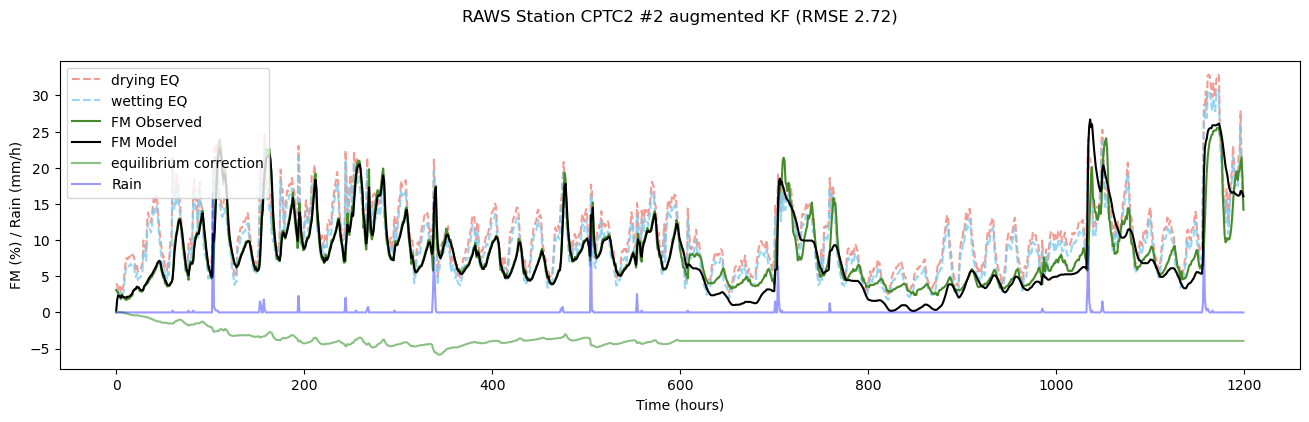

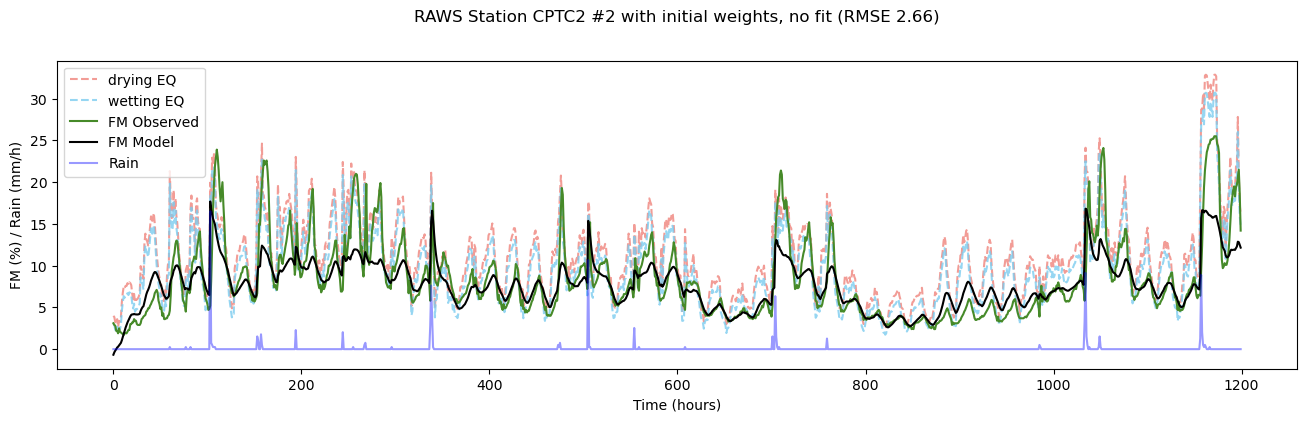

case8 Training 1 to 600 hours RMSE:   2.8486
case8 Prediction 601 to 1200 hours RMSE: 2.6608
resetting random seeds to 123
scaling to range 0 to 0.8
batch_size= 32
staircase_2: shape x =  (1200, 3)
staircase_2: shape y =  (1200, 1)
staircase_2: timesteps= 5
staircase_2: batch_size= 32
staircase_2: return_sequences= False
staircase_2: datapoints= 600
staircase_2: max_batches= 120
staircase_2: max_sequences= 3840
staircase_2: shape x_train =  (3840, 5, 3)
staircase_2: shape y_train =  (3840, 1)
staircase_2: sequences generated 3728
staircase_2: batch_size= 32
staircase_2: removing partial and empty batches at the end, keeping 3712
staircase_2: shape x_train =  (3712, 5, 3)
staircase_2: shape y_train =  (3712, 1)
train_rnn : samples = 3712
train_rnn : features = 3
train_rnn : timesteps = 5
train_rnn : centering = [0.0, 0.0]
train_rnn : training = 5
train_rnn : batch_size = 32
train_rnn : epochs = 10000
x_train shape = (3712, 5, 3)
y_train shape = (3712, 1)
training in one pass, resetting 

In [ ]:
output={}
print('params_sets.keys()=',param_sets.keys())
print(json.dumps(param_sets,indent=4,sort_keys=True))

for i in param_sets:
#for params in param_sets:
    print('i=',i)
    params=param_sets[i]
    if i == 0:
        # Run reproducbility case
        print('Running reproducibility')
        assert param_sets[i]['purpose'] == 'reproducibility'
        output[i]={'params':params,'cases':{}}
        case = 'case11'
        case_data=repro_dict[case]
        output[i]['cases'][case]=run_case(case_data,params)
        print('*** params',i,'reproducibility case','summary ***')
        print('params=',params)
        print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
        print('writing the results to file',output_path)
        json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
    else:
        #print('params=',params)
        if params['cases'] == 'all':
            params['cases'] = list(test_dict.keys())
            print("expanding 'all' to",params['cases'])
        output[i]={'params':params,'cases':{}}
        cases = params['cases']
        print('cases=',cases)
        for case in cases:
            print('case=',case)
            # print(json.dumps(params,indent=4,sort_keys=True))
            case_data=test_dict[case]
            if not 'title' in case_data.keys():
                case_data['title']=case
            if not 'hours' in case_data.keys():
                case_data['hours']=len(case_data['fm'])
                # case_data['h2']=int(20*24) # length of training period
            if params['synthetic'] or 'Synth' not in case_data['title']: 
                output[i]['cases'][case]=run_case(case_data,params)  # add to results
                print('*** params',i,'case',case,'summary ***')
                print('params=',params)
                print('outputs=',json.dumps(output[i]['cases'][case],indent=4,sort_keys=True))
                print('writing the results to file',output_path)
                json.dump(output,open(output_path,'w'),indent=4,sort_keys=True)
        print('cases=',cases)
print(json.dumps(output,indent=4,sort_keys=True))
   